References:

1. Generative Deep Learning - David Foster
2. Variational Autoencoder: Intuition and Implementation - Agustinus Kristiadi
3. Deep Learning with Python - Francois Chollet

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets

In [ ]:
#takes a list of flattened image data and plots the image list in rows
def plotImage(x_img, cols=5):
  #pick five random indices from the sample range of the image data
  random_sample_indices = [np.random.randint(low=0, high=x_img[0].shape[0]) for i in range(5)]
  #select the five images
  random_sample_images = x_img[0][random_sample_indices, :]

  #number of rows to be plotted
  rows = len(x_img)
  #create subplot axes
  fig, ax = plt.subplots(nrows=rows, ncols=cols, squeeze=False)

  for row in range(rows):
    for i, index in enumerate(random_sample_indices):
      #the image pixels are in flattened array
      #reshape the pixel array to 28*28 dimension
      ax[row, i].imshow(x_img[row][index].reshape(28,28), cmap='gray')
      ax[row, i].grid=False
      ax[row, i].set_xticks([])
      ax[row, i].set_yticks([])

  return ax, fig

## Getting Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

[]

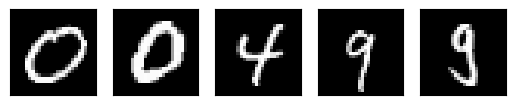

In [ ]:
#plot five random digits
ax, fig = plotImage([x_train], cols=5)
plt.plot()

## Preprocessing input

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [ ]:
#flatten the pixel array of the images
def reshapeImage(images, normalize=False):
  images_reshaped = images.reshape((images.shape[0], images.shape[1]*images.shape[2]))

  if normalize:
    #reduce the range of values to [0,1]
    images_reshaped = images_reshaped.astype('float32')/255

  return images_reshaped

In [ ]:
#flatten and normalize the pixel values of the digits to [0,1]
x_train_reshaped = reshapeImage(x_train, normalize=True)
x_test_reshaped = reshapeImage(x_test, normalize=True)

In [ ]:
print(x_train_reshaped.shape)
print(x_test_reshaped.shape)

(60000, 784)
(10000, 784)


#Variational autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch_size = tf.shape(z_mean)[0]
    units = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, units), mean=0, stddev=1)
    return z_mean + tf.math.exp(z_log_var/2)*epsilon

In [ ]:
class VAE(Model):
  def __init__(self, encoder, decoder, beta_rec=500., beta_kl=1., **kwargs):
    super().__init__(**kwargs)

    self.encoder = encoder
    self.decoder = decoder

    self.beta_rec = beta_rec
    self.beta_kl = beta_kl

    self.total_loss = keras.metrics.Mean(name='total_loss')
    self.total_reconstruction_loss = keras.metrics.Mean(name='reconstruction_loss')
    self.total_kl_loss = keras.metrics.Mean(name='kl_loss')

  @property
  def metrics(self):
    return [self.total_loss, self.total_reconstruction_loss, self.total_kl_loss]

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    predictions = self.decoder(z)

    return z_mean, z_log_var, z, predictions

  def train_step(self, data):
    inputs, outputs = data
    with tf.GradientTape() as tape:
      #z_mean, z_log_var, z = self.encoder(inputs)
      #predictions = self.decoder(z)
      z_mean, z_log_var, z, predictions = self(inputs)

      reconstruction_loss = self.beta_rec*tf.reduce_sum(keras.losses.binary_crossentropy(outputs, predictions, axis=0))
      kl_loss = 0.5*self.beta_kl*tf.reduce_mean(tf.reduce_sum((tf.square(z_mean) + tf.exp(z_log_var) -  z_log_var), axis=1))
      loss = reconstruction_loss + kl_loss

      gradients = tape.gradient(loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

      self.total_reconstruction_loss.update_state(reconstruction_loss)
      self.total_kl_loss.update_state(kl_loss)
      self.total_loss.update_state(loss)

      return {m.name: m.result() for m in self.metrics}

In [ ]:
input_size = 28*28
latent_dim = 2

input = Input(shape=(input_size,), name='input_layer')
encoder_l1 = Dense(64, activation='relu', name='encoder_layer1')(input)
#encoder_l2 = Dense(100, activation='relu', name='encoder_layer2')(encoder_l1)
z_mean = Dense(latent_dim, activation='relu', name='z_mean')(encoder_l1)
z_log_var = Dense(latent_dim, activation='relu', name='z_log_var')(encoder_l1)

z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs=input, outputs=[z_mean, z_log_var, z], name='encoder')

In [ ]:
latent_layer = Input(shape=(latent_dim,), name='latent_layer')
decoder_l1 = Dense(64, activation='relu', name='decoder_layer1')(latent_layer)
#decoder_l2 = Dense(400, activation='relu', name='decoder_layer2')(decoder_l1)
decoder_out = Dense(input_size, activation='sigmoid', name='decoder_layer_out')(decoder_l1)

decoder = Model(inputs=latent_layer, outputs=decoder_out, name='decoder')

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=1., beta_kl=0.001)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_reshaped, x_train_reshaped, batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 9s 12ms/step - total_loss: 149.7986 - reconstruction_loss: 148.8290 - kl_loss: 0.9695
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - total_loss: 149.7443 - reconstruction_loss: 148.7596 - kl_loss: 0.9847
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - total_loss: 149.6437 - reconstruction_loss: 148.6497 - kl_loss: 0.9940
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - total_loss: 149.5900 - reconstruction_loss: 148.5796 - kl_loss: 1.0103
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - total_loss: 149.5504 - reconstruction_loss: 148.5325 - kl_loss: 1.0181
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - total_loss: 149.4849 - reconstruction_loss: 148.4555 - kl_loss: 1.0294
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - total_loss: 149.4093 - reconstruction_loss: 148.3698 - kl_loss: 1.0396
Epoch 8/10
469/469 [====

In [ ]:
latent_z_mu, latent_z_logvar, latent_z, x_prediction_reshaped = variational_autoencoder.predict(x_test_reshaped)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(tf.math.reduce_mean(z, axis=0))
print(tf.math.reduce_variance(z, axis=0))

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.float32, name=None), name='tf.math.reduce_mean_1/Mean:0', description="created by layer 'tf.math.reduce_mean_1'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.float32, name=None), name='tf.math.reduce_variance/reduce_variance/Mean_1:0', description="created by layer 'tf.math.reduce_variance'")


[]

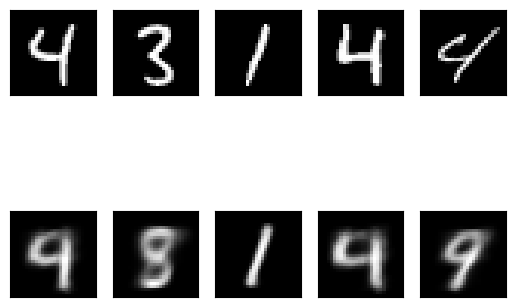

In [ ]:
#plot five random digits
ax, fig = plotImage([x_test_reshaped, x_prediction_reshaped], cols=5)
plt.plot()

#Denoising using Autoencoder

Let us introduce some noise to the images and see how the autoencoder performs on the noised images.

In [ ]:
#create noises for the training and test datasets as random values
train_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_train_reshaped.shape[1]))
test_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_test_reshaped.shape[1]))

In [ ]:
#add the noise
x_train_noise = x_train_reshaped + train_noise
x_test_noise = x_test_reshaped + test_noise
#clip the noise in the range [0,1]
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

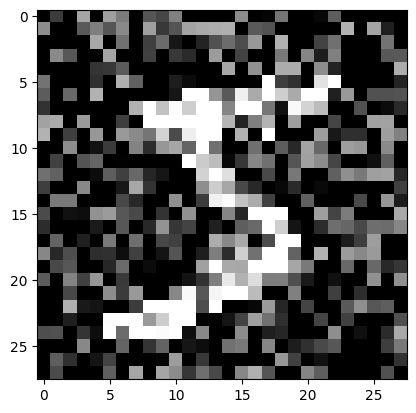

In [ ]:
plt.imshow(x_train_noise[0].reshape(28,28), cmap='gray')

In [ ]:
z_mu, z_logvar, z, x_prediction_noise = variational_autoencoder.predict(x_test_noise)

313/313 [==============================] - 3s 9ms/step


[]

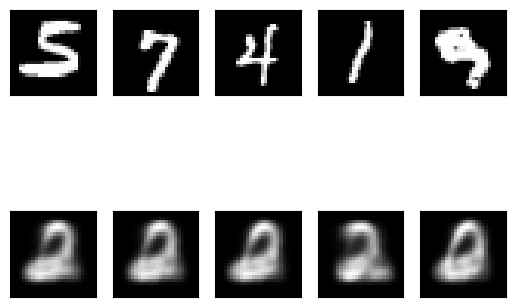

In [ ]:
ax, fig = plotImage([x_test, x_prediction_noise])
plt.plot()

We see that the encoder is performing badly for the noised data. This is because the encoder is not trained to remove the noise. So, lets pass the encoder noised data and train it to produce denoised images.

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=1., beta_kl=0.001)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_noise, x_train_reshaped, batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 5s 7ms/step - total_loss: 180.3165 - reconstruction_loss: 180.1230 - kl_loss: 0.1935
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - total_loss: 168.4502 - reconstruction_loss: 168.1562 - kl_loss: 0.2941
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - total_loss: 165.6058 - reconstruction_loss: 165.2462 - kl_loss: 0.3595
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - total_loss: 164.0962 - reconstruction_loss: 163.6895 - kl_loss: 0.4066
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - total_loss: 163.0381 - reconstruction_loss: 162.5865 - kl_loss: 0.4516
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - total_loss: 162.2113 - reconstruction_loss: 161.7140 - kl_loss: 0.4973
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - total_loss: 161.5793 - reconstruction_loss: 161.0414 - kl_loss: 0.5377
Epoch 8/10
469/469 [=====

Now, lets pass the noised test images to the encoder trained to remove noise.

In [ ]:
z_mu, z_logvar, z,  x_prediction_noise = variational_autoencoder.predict(x_test_noise)

313/313 [==============================] - 1s 3ms/step


[]

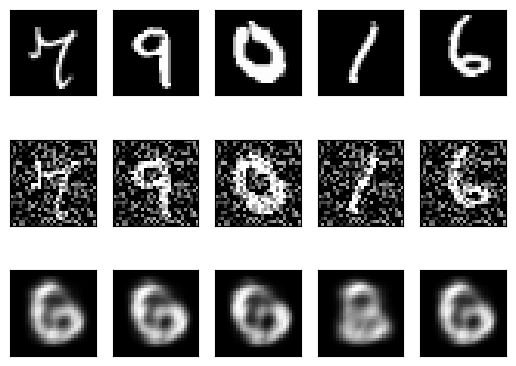

In [ ]:
ax, fig = plotImage([x_test, x_test_noise, x_prediction_noise])
plt.plot()

[]

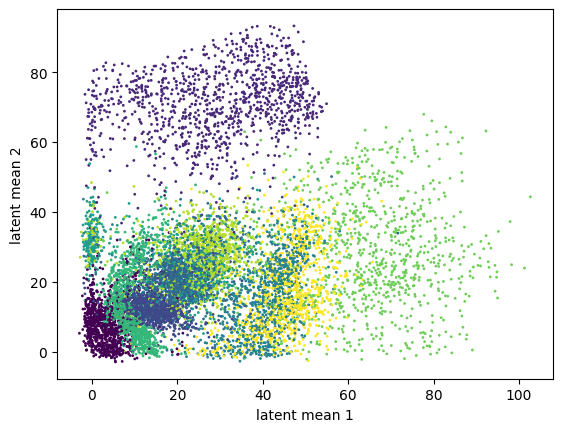

In [ ]:
plt.scatter(latent_z[:,0], latent_z[:,1], s=1, c=y_test)
plt.xlabel('latent mean 1')
plt.ylabel('latent mean 2')
plt.plot()

We see that most of the dataset are clustered around origin. Also, there is no sharp segregation of the data based on the digits. This is because the latent space is continuous. So, the different digits transform smoothly as one moves from one region to another.

In [ ]:
num_digits_row = 20
digit_dim = 28
fig_size = 28*num_digits_row

mu1_range, mu2_range = 40, 40

means1 = np.linspace(-mu1_range, mu1_range, num_digits_row)
means2 = np.linspace(-mu2_range, mu2_range, num_digits_row)
figure = np.zeros((fig_size, fig_size))

for mu1_index, mu1 in enumerate(means1):
  for mu2_index, mu2 in enumerate(means2):
    z = np.array([[mu1, mu2]])
    digit = decoder.predict(z)
    digit = digit.reshape(digit_dim, digit_dim)

    figure[mu2_index*digit_dim:(mu2_index+1)*digit_dim,  mu1_index*digit_dim:(mu1_index+1)*digit_dim] = digit

1/1 [==============================] - 0s 20ms/step


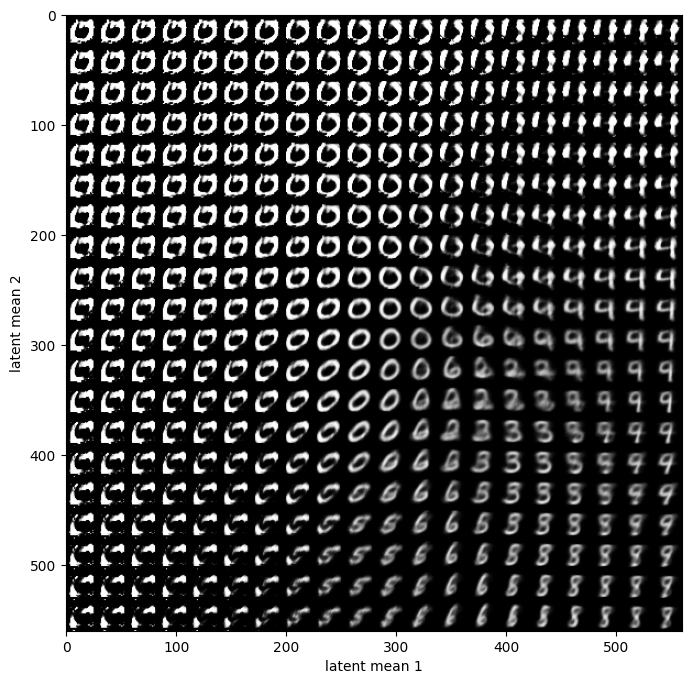

In [ ]:
plt.figure(figsize=(8,8))
plt.xlabel('latent mean 1')
plt.ylabel('latent mean 2')
plt.imshow(figure, cmap='gray')